# The "Asia"  graphical model

We illustrate inference in the "Asia" medical diagnosis network.
Network is from http://www.bnlearn.com/bnrepository/#asia.


In [1]:
!pip install  causalgraphicalmodels
!pip install pgmpy

#!ls /usr/local/lib/python3.7/dist-packages/pgmpy/utils

     |████████████████████████████████| 337kB 8.0MB/s 


In [2]:
from causalgraphicalmodels import CausalGraphicalModel
import pgmpy
import numpy as np
import pandas as pd
from graphviz import Digraph

# Model

In [3]:
#from pgmpy.utils import get_example_model
#asia = get_example_model('asia')
# No such file or directory: 'pgmpy/utils/example_models/asia.bif.gz'

In [4]:
#!wget https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/torch.py -q -O d2l.py

!wget https://www.bnlearn.com/bnrepository/asia/asia.bif.gz -q -O asia.bif.gz
!gunzip asia.bif.gz

In [5]:
from pgmpy.readwrite import BIFReader, BIFWriter
reader = BIFReader("asia.bif")
model = reader.get_model()

print("Nodes: ", model.nodes())
print("Edges: ", model.edges())
model.get_cpds()

Nodes:  ['asia', 'tub', 'smoke', 'lung', 'bronc', 'either', 'xray', 'dysp']
Edges:  [('asia', 'tub'), ('tub', 'either'), ('smoke', 'lung'), ('smoke', 'bronc'), ('lung', 'either'), ('bronc', 'dysp'), ('either', 'xray'), ('either', 'dysp')]


[<TabularCPD representing P(asia:2) at 0x7f5bb534f090>,
 <TabularCPD representing P(bronc:2 | smoke:2) at 0x7f5bb59f3950>,
 <TabularCPD representing P(dysp:2 | bronc:2, either:2) at 0x7f5bb6a11c10>,
 <TabularCPD representing P(either:2 | lung:2, tub:2) at 0x7f5bb53c4f90>,
 <TabularCPD representing P(lung:2 | smoke:2) at 0x7f5bb5355bd0>,
 <TabularCPD representing P(smoke:2) at 0x7f5bb5355e10>,
 <TabularCPD representing P(tub:2 | asia:2) at 0x7f5bb5355a90>,
 <TabularCPD representing P(xray:2 | either:2) at 0x7f5bb5355c90>]

In [6]:
for c in model.get_cpds():
  print(c)

+-----------+------+
| asia(yes) | 0.01 |
+-----------+------+
| asia(no)  | 0.99 |
+-----------+------+
+------------+------------+-----------+
| smoke      | smoke(yes) | smoke(no) |
+------------+------------+-----------+
| bronc(yes) | 0.6        | 0.3       |
+------------+------------+-----------+
| bronc(no)  | 0.4        | 0.7       |
+------------+------------+-----------+
+-----------+-------------+------------+-------------+------------+
| bronc     | bronc(yes)  | bronc(yes) | bronc(no)   | bronc(no)  |
+-----------+-------------+------------+-------------+------------+
| either    | either(yes) | either(no) | either(yes) | either(no) |
+-----------+-------------+------------+-------------+------------+
| dysp(yes) | 0.9         | 0.8        | 0.7         | 0.1        |
+-----------+-------------+------------+-------------+------------+
| dysp(no)  | 0.1         | 0.2        | 0.3         | 0.9        |
+-----------+-------------+------------+-------------+------------+
+--

In [7]:
asia_cpd = model.get_cpds()[0]
print(asia_cpd)
print(asia_cpd.values)
asia_prior_true = asia_cpd.values[1]

+-----------+------+
| asia(yes) | 0.01 |
+-----------+------+
| asia(no)  | 0.99 |
+-----------+------+
[0.01 0.99]


In [8]:
smoking_cpd = model.get_cpds()[5]
print(smoking_cpd)
print(smoking_cpd.values)
smoking_prior_true = smoking_cpd.values[1]

+------------+-----+
| smoke(yes) | 0.5 |
+------------+-----+
| smoke(no)  | 0.5 |
+------------+-----+
[0.5 0.5]


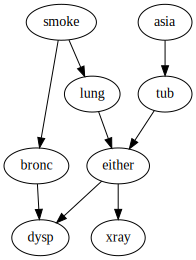

'Digraph.gv.pdf'

In [9]:
asia = CausalGraphicalModel(nodes = model.nodes(), edges=model.edges())
nodes = model.nodes()
out = asia.draw()
display(out)
out.render()

# Inference

In [10]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

In [11]:
def get_marginals(evidence = {}):
  nodes = model.nodes()
  num_nodes = len(nodes)
  marginals = dict()
  for n in nodes:
    if n in evidence: # observed nodes
      v = evidence[n]
      if v == 1:      
        marginals[n] = 1.0 # clamped to state 1
      else:
        marginals[n] = 0.0 # clamped to state 0
    else:
      probs = infer.query([n], evidence=evidence).values
      marginals[n] = probs[1] # probability in state 1
  return marginals


In [12]:
def visualization(marginals, model):
  h = Digraph('asia_net')
  titles = list(marginals.keys())
  yes_prob = list(marginals.values())
  no_prob = [1 - x for x in yes_prob]
  for i in range(len(marginals)):
    h.node(titles[i], label='''<<TABLE>
      <TR PORT="header">
          <TD BGCOLOR="#d23939" COLSPAN="2"> {} </TD>
      </TR>
      <TR>
        <TD>yes</TD>
        <TD>{:.2f}</TD>
      </TR>
      <TR>
        <TD>no</TD>
        <TD>{:.2f}</TD>
      </TR>
    </TABLE>>'''.format(titles[i], yes_prob[i], no_prob[i]))

  edges = (model.edges())
  for item in edges:
    edge = list(item)
    h.edge(edge[0], edge[1])
  
  return h


## Prior marginals

Eliminating: either: 100%|██████████| 7/7 [00:00<00:00, 325.55it/s]


asia 0.99
tub 0.9896
smoke 0.49999999999999994
lung 0.945
bronc 0.55
either 0.935172
xray 0.88970996
dysp 0.5640294


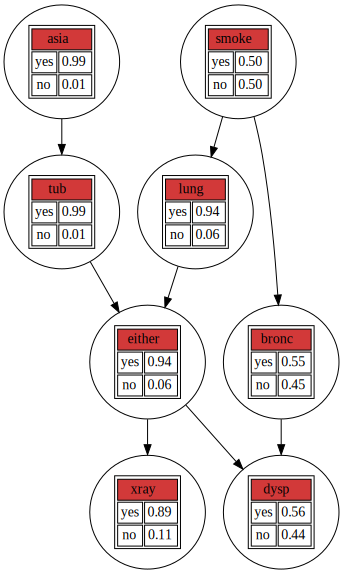

In [13]:
marginals = get_marginals()
for k, v in marginals.items():
  print(k, v)
assert np.allclose(asia_prior_true, marginals['asia']) #Asia (0.5, 0.5)
h = visualization(marginals, model)
h

## Posterior marginals given dsypnea=present

/usr/local/lib/python3.7/dist-packages/pgmpy/factors/discrete/DiscreteFactor.py:519: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Eliminating: either: 100%|██████████| 6/6 [00:00<00:00, 261.85it/s]




asia 0.9896750491890968
tub 0.9811546925411943
smoke 0.3660031203938981
lung 0.8972407772450711
bronc 0.1660326636704402
either 0.8794641657029166
xray 0.8379016741037125
dysp 0.0


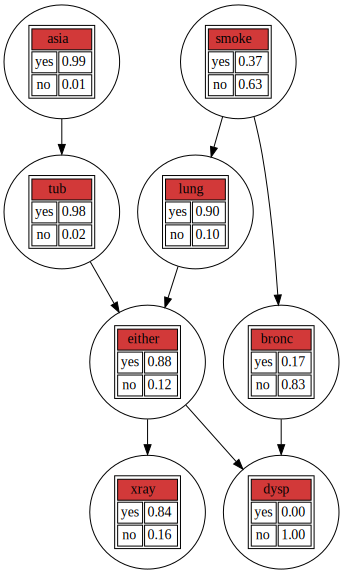

In [14]:
evidence  = {'dysp': 0}
marginals = get_marginals(evidence)
print('\n')
for k, v in marginals.items():
  print(k, v)
h = visualization(marginals, model)
h

## Posterior marginals given dsypnea=present, asia=visit

/usr/local/lib/python3.7/dist-packages/pgmpy/factors/discrete/DiscreteFactor.py:519: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Eliminating: either: 100%|██████████| 5/5 [00:00<00:00, 344.35it/s]




asia 0.0
tub 0.9122490350170781
smoke 0.3740801421787787
lung 0.9004748549054455
bronc 0.1885979284107634
either 0.8177001471772514
xray 0.7804611368748438
dysp 0.0


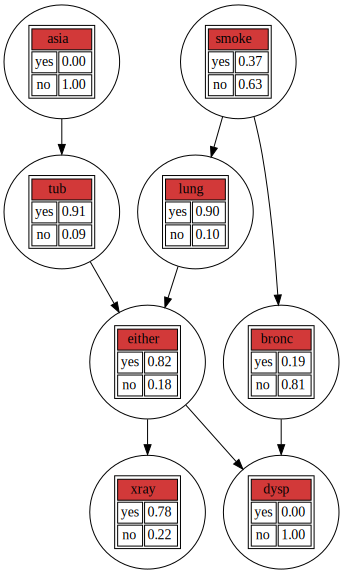

In [15]:
evidence  = {'dysp': 0, 'asia': 0}
marginals = get_marginals(evidence)
print('\n')
for k, v in marginals.items():
  print(k, v)
h = visualization(marginals, model)
h

## Posterior marginals given dsypnea=present, asia=visit, smoking=true

/usr/local/lib/python3.7/dist-packages/pgmpy/factors/discrete/DiscreteFactor.py:519: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Eliminating: either: 100%|██████████| 4/4 [00:00<00:00, 375.14it/s]




asia 0.0
tub 0.927240461401952
smoke 0.0
lung 0.8544809228039041
bronc 0.13274179236912156
either 0.7889973380656611
xray 0.7537675244010646
dysp 0.0


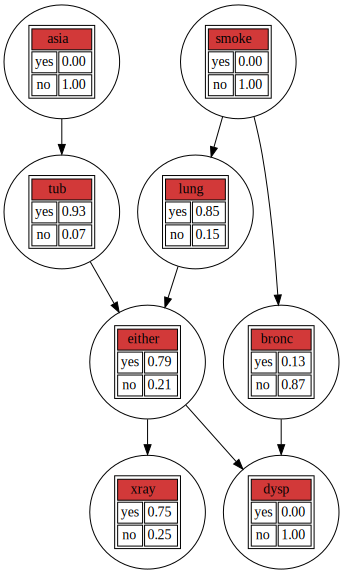

In [16]:
evidence  = {'dysp': 0, 'asia': 0, 'smoke': 0}
marginals = get_marginals(evidence)
print('\n')
for k, v in marginals.items():
  print(k, v)
h = visualization(marginals, model)
h

# Visualization of posterior marginals


<img src="https://user-images.githubusercontent.com/4632336/118872284-40b65700-b89d-11eb-8739-bc94fce6808a.png?raw=true">



# Explanatory text from the book.

In this section,
we consider a hypothetical medical
model proposed in \citep{Lauritzen88}
which is
known in the literature as the ``\keywordDef{Asia network}''.
(The name comes  from the fact
that was designed to diagnoise various
lung diseases in Western patients returning from a trip to Asia.
Note that this example predates 
the \COVID pandemic by many years, and is a purely fictitious model.)

\cref{fig:pgmAsia1} shows the model, as well as the prior
marginal distributions over each node (assumed to be binary).
Now suppose the patient reports that they have \keywordDef{Dyspnea},
aka shortness of breath.
We can represent this fact
``clamping'' the distribution to be 100\% probability
that Dyspnea=Present, and 0\% probability that Dyspnea=Absent.
We then propagate this new  information  through the network
to get the updated marginal distributions shown in
\cref{fig:pgmAsia2}.
We see that the probability
of lung cancer has gone up from 5\% to 10\%,
and probability of bronchitis has gone up  from 45\% to 83\%.

However, it could also be a an undiagnosed case of TB (tuberculosis),
which may have been caused by exposure to an infectious lung disease
that was prevalent in Asia at the time.
So he doctor asks the patient if they have recently been to Asia,
and they say yes.  \cref{fig:pgmAsia3} shows the new belief state of each node.
We see that the probability of TB has increased from 2\% to 9\%.
However, Bronchitis remains the most likely explanation of the symptoms.

To gain more information the doctor asks
if the patient smokes, and they say yes.
\cref{fig:pgmAsia3} shows the new belief state of each node.
Now the probability of cancer and bronchitis have both gone up.
In addition, the posterior predicted probability that an X-ray
will show an abnormal result has gone up to 24\%, so the doctor may decide
it is now worth ordering a test to verify this hypothesis.

This example illustrates the nature of recursive Bayesian updating,
and how it can be useful for active learning and sequential decision making,
We will see more examples later in the book.